## NSMC를 딥러닝으로 해보자!

* 불러온 데이터를 품사 태그를 붙여서 토크나이징합니다.

In [1]:
import MeCab
from konlpy.tag import Okt
import json
import os
import re
from pprint import pprint

okt = Okt()
mecab = MeCab.Tagger()

if os.path.exists('train_docs.json'):
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:
    train_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in train_docs if text_tokenizing(line[1])]
    #train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
    
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('test_docs.json'):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in test_docs if text_tokenizing(line[1])]
    #test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[['평점', '나쁘', '지만', '짜리', '더더욱', '아니', '잖아'], '0']


In [2]:
print(train_data[:3])

[[['진짜', '짜증', '네요', '목소리'], '0'], [['포스터', '보고', '초딩', '영화', '오버', '연기', '조차', '가볍', '구나'], '1'], [['너무', '밓었다그래서보는것을추천한다'], '0']]


* 데이터 분석을 하기 위해 기본적인 정보들을 확인합니다.

* nltk 라이브러리를 이용하여 전처리를 합니다.

## Deep Neural Network로 분류하기

In [5]:
# 필요한 라이브러리 불러오기
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences ## 단어간 길이를 맞춰줌 (짧은 단어의 빈칸 채워줌)
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential ## Sequential object에 layer를 추가하는 방식으로 네트워크 구성함

## Set Hyperparameter 

In [6]:
max_words = 35000
max_len = 30 # 문서(= 리뷰한개)의 최대길이 
batch_size = 128
EPOCHS = 4

## Define Network Structure 

In [7]:
class SimpleLSTM(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb = Embedding(max_words, 100) # 각 노드가 100차원
        self.lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2) # dropout -> 정규화
        self.dense = Dense(1, activation="sigmoid")
        
    def __call__(self, x, training=None, mask=None):
        x = self.emb(x)
        x = self.lstm(x)
        return self.dense(x)

## Data Preprocessing 

In [10]:
# SVM 때와 비슷한 형태로 만들고
x_train = [doc for doc, _ in train_data]
x_test = [doc for doc, _ in test_data]
y_train = [int(label) for _, label in train_data]
y_test = [int(label) for _, label in test_data ]

# keras가 사용하기 위한 형태로 Tokenizing
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

# LSTM의 input으로 넣기 위한 변환 작업
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
y_train = np.array(y_train) # np.int64로 타입을 변환해줌
y_test = np.array(y_test) 
print(x_train[0])

# 크기를 맞춰주기 위한 zero padding
x_train = pad_sequences(x_train, value=0, padding='pre', maxlen=max_len)
x_test = pad_sequences(x_test, value=0, padding='pre', maxlen=max_len)
print('\n', x_train[0])
    
# 학습 가능한 형태로 최종 변환.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[9, 110, 7, 456]

 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   9 110   7 456]


## Set Model 

In [12]:
# 모델 선언
model = SimpleLSTM()

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Early Stopping Callback

In [14]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)

## Run Model 

In [15]:
# 실행, 결과 저장.
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=earlystopper)

Epoch 1/4
1145/1145 [==============================] - 276s 241ms/step - loss: 0.4182 - accuracy: 0.8046 - val_loss: 0.3862 - val_accuracy: 0.8218
Epoch 2/4
1145/1145 [==============================] - 251s 219ms/step - loss: 0.3318 - accuracy: 0.8542 - val_loss: 0.3910 - val_accuracy: 0.8250
Epoch 3/4
1145/1145 [==============================] - 236s 207ms/step - loss: 0.2791 - accuracy: 0.8790 - val_loss: 0.4246 - val_accuracy: 0.8210
Epoch 4/4
1145/1145 [==============================] - 192s 168ms/step - loss: 0.2276 - accuracy: 0.9036 - val_loss: 0.4950 - val_accuracy: 0.8134


In [16]:
# Model Test
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)

382/382 [==============================] - 10s 26ms/step - loss: 0.4950 - accuracy: 0.8134


In [17]:
print("Test Score: ", score)
print("Test Accuracy: ", acc)

Test Score:  0.49496838450431824
Test Accuracy:  0.8133644461631775


## Loss Visualization 

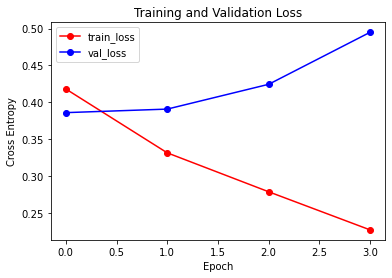

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-', label="train_loss")
plt.plot(val_loss, 'bo-', label="val_loss")
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.title('Training and Validation Loss')
plt.show()

## Save Weight 

In [19]:
# Model weight matrix 저장.
model.save_weights('nsmc_keras_simplelstm')